In [247]:
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np

import warnings
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

import torchvision
from torchvision import transforms
from torchsummary import summary

from albumentations import (
    ToFloat, 
    CLAHE, 
    RandomRotate90, 
    Transpose, 
    ShiftScaleRotate, 
    Blur, 
    OpticalDistortion, 
    GridDistortion, 
    HueSaturationValue, 
    IAAAdditiveGaussianNoise, 
    GaussNoise, 
    MotionBlur, 
    MedianBlur, 
    IAAPiecewiseAffine, 
    IAASharpen, 
    IAAEmboss, 
    RandomContrast, 
    RandomBrightness, 
    Flip, 
    OneOf, 
    Compose
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numbers
from sklearn.model_selection import train_test_split

from PIL import Image
import math
from tqdm import tqdm

import os
from tqdm import tqdm_notebook as tqdm

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import matplotlib.patches as patches
import seaborn as sns
from pylab import rcParams

%matplotlib inline 
plt.style.use('seaborn')
sns.set(style='whitegrid',color_codes=True)

# classifiaction 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
import catboost as ctb

# for classification
from sklearn.metrics import accuracy_score

# model selection
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Hp optimization imports
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import mlflow

import re
import eli5
import gc
import random    
import math
import psutil
import pickle
import datetime
from time import time

# save/load models
from joblib import dump
from joblib import load


import numpy
from keras.optimizers import Adam
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Activation
from keras.optimizers import Adam
# fix random seed for reproducibility
numpy.random.seed(7)
from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, train_test_split, GroupKFold, GroupShuffleSplit

from numpy import zeros, newaxis

In [2]:
# https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/
# https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras-part-2/

In [269]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
from keras.models import load_model

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [217]:
root = "../../data/raw/Gamma_Log_Facies_Type_Prediction/"
models_root = "../../models/Gamma_Log_Facies_Type_Prediction/"
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
pd.set_option('max_columns', 150)
# rcParams['figure.figsize'] = 16,8

In [218]:
%%time
full_train_df = pd.read_csv(root + "Train_File.csv")
full_test_df = pd.read_csv(root + "Test_File.csv")
submit_df = pd.read_csv(root + "Submission_File.csv")


CPU times: user 3.11 s, sys: 553 ms, total: 3.66 s
Wall time: 3.72 s


In [219]:
full_train_df.shape, full_test_df.shape, submit_df.shape

((4400000, 4), (2200000, 4), (2200000, 2))

In [223]:
full_test_df

,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.950000
1,CAX_1,1,5000,120.896397
2,CAX_2,2,5000,115.342793
3,CAX_3,3,5000,118.859190
4,CAX_4,4,5000,127.735587
...,...,...,...,...
2199995,CAX_2199995,1095,6999,145.376324
2199996,CAX_2199996,1096,6999,140.877243
2199997,CAX_2199997,1097,6999,111.248162
2199998,CAX_2199998,1098,6999,148.859081


In [224]:
train = np.array([x.values[:,2:3].T for group, x in full_train_df.groupby('well_id')], dtype='float32')
target = np.array([x.values[:,3:].T for group, x in full_train_df.groupby('well_id')], dtype='float32')
test = np.array([x.values[:,3:4].T for group, x in full_test_df.groupby('well_id')], dtype='float32')

In [225]:
train.shape, target.shape, test.shape

((4000, 1, 1100), (4000, 1, 1100), (2000, 1, 1100))

In [226]:
test[0]

array([[113.95  , 120.8964, 115.3428, ..., 168.1972, 157.1136, 166.81  ]],
      dtype=float32)

In [93]:
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            cats.append(np.zeros(categories))
            cats[-1][item] = 1.0
        cat_sequences.append(cats)
    return np.array(cat_sequences)

In [227]:
train_X = train.reshape(train.shape[0], train.shape[2])
train_y = target.reshape(target.shape[0], target.shape[2])
test_X = test.reshape(test.shape[0], test.shape[2])

In [95]:
def show_history(history, metric='mse'):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [228]:
train_X.shape, train_y.shape, test_X.shape

((4000, 1100), (4000, 1100), (2000, 1100))

In [229]:
train_X = train_X[:, :, newaxis]
test_X = test_X[:, :, newaxis]

In [99]:
train_y[0]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [100]:
train_y = train_y.astype(int)

In [101]:
train_y[0]

array([0, 0, 0, ..., 0, 0, 0])

In [102]:
train_y_cat = to_categorical(train_y, 5)
print(train_y_cat[0])

[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [230]:
train_X.shape, train_y_cat.shape, test_X.shape

((4000, 1100, 1), (4000, 1100, 5), (2000, 1100, 1))

In [82]:
train_y_cat = train_y_cat[:, :, :, newaxis]

In [107]:
train_X.shape, train_y_cat.shape, test_X.shape

((4000, 1100, 1), (4000, 1100, 5), (2000, 1100, 1))

In [285]:
del model

In [286]:
# epoch = 40, result = 0.95607

model = Sequential()
model.add(Bidirectional(LSTM(256, input_shape=(1100, 1), return_sequences=True)))
model.add(TimeDistributed(Dense(5)))
model.add(Activation('softmax'))

learning_rate = 0.001
epochs = 40
decay_rate = learning_rate / epochs
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
adam = Adam(learning_rate, decay=decay_rate)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [287]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling build() or calling fit() with some data. Or specify input_shape or batch_input_shape in the first layer for automatic build. 

In [288]:
%%time

history = model.fit(train_X, train_y_cat, batch_size=256, epochs=2, validation_split=0.2, callbacks=[es, mc])

Train on 3200 samples, validate on 800 samples
Epoch 1/2
3200/3200 [==============================] - 349s 109ms/step - loss: 1.1149 - accuracy: 0.5905 - val_loss: 0.9148 - val_accuracy: 0.6501

Epoch 00001: val_accuracy improved from -inf to 0.65012, saving model to best_model.h5
Epoch 2/2
3200/3200 [==============================] - 383s 120ms/step - loss: 0.8648 - accuracy: 0.6734 - val_loss: 0.7954 - val_accuracy: 0.7081

Epoch 00002: val_accuracy improved from 0.65012 to 0.70811, saving model to best_model.h5
CPU times: user 29min 3s, sys: 20min 17s, total: 49min 21s
Wall time: 12min 17s


In [289]:
model_1 = load_model('best_model.h5')

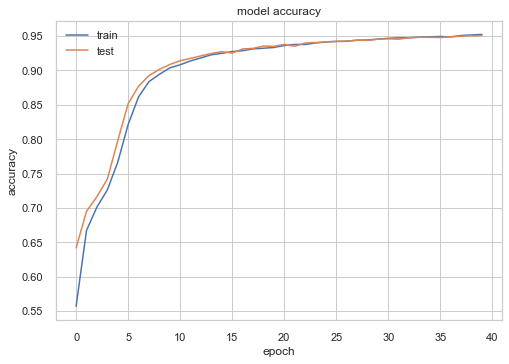

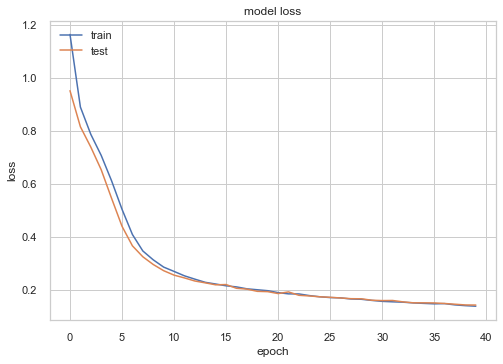

In [258]:
show_history(history, 'accuracy')

In [290]:
%%time

history = model_1.fit(train_X, train_y_cat, batch_size=256, epochs=1, validation_split=0.2, callbacks=[es, mc])

Train on 3200 samples, validate on 800 samples
Epoch 1/1
3200/3200 [==============================] - 325s 101ms/step - loss: 0.7640 - accuracy: 0.7130 - val_loss: 0.7050 - val_accuracy: 0.7271

Epoch 00001: val_accuracy improved from 0.70811 to 0.72713, saving model to best_model.h5
CPU times: user 13min 58s, sys: 9min 35s, total: 23min 33s
Wall time: 5min 24s


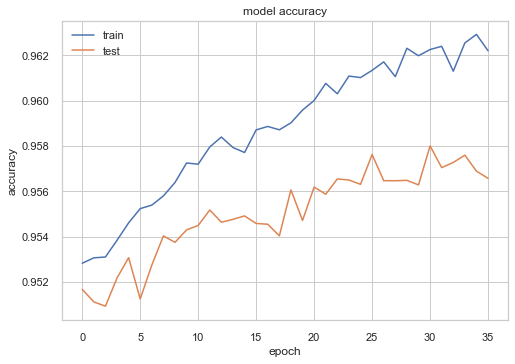

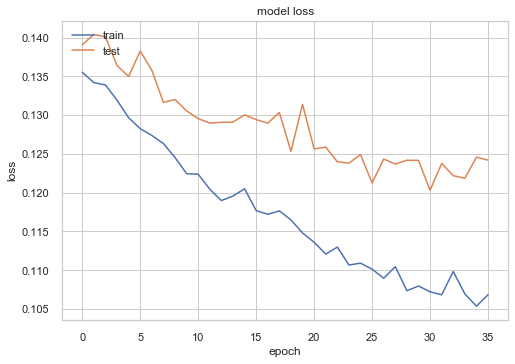

In [268]:
show_history(history, 'accuracy')

In [282]:
model_1 = load_model('best_model.h5')

ValueError: You are trying to load a weight file containing 2 layers into a model with 0 layers

In [232]:
test_X.shape

(2000, 1100, 1)

In [273]:
%%time

y_hat = model.predict(test_X)

CPU times: user 3min 18s, sys: 53.5 s, total: 4min 12s
Wall time: 44.4 s


In [274]:
r = y_hat.reshape((-1,5))

In [276]:
r.shape

(2200000, 5)

In [277]:
predict = argmax(y_hat.reshape((-1,5)), axis=1)

In [278]:
predict.shape

(2200000,)

In [279]:
submit_df.shape

(2200000, 2)

In [280]:
submit_df["label"] = predict
submit_df.to_csv(root+"submission.csv", index=False)
submit_df.head(20)

,unique_id,label
0,CAX_0,0
1,CAX_1,0
2,CAX_2,0
3,CAX_3,0
4,CAX_4,0
5,CAX_5,0
6,CAX_6,0
7,CAX_7,0
8,CAX_8,4
9,CAX_9,4


<BarContainer object of 5 artists>

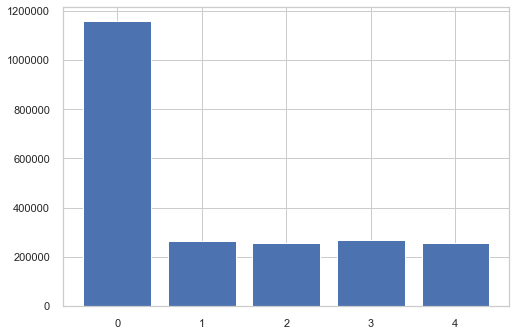

In [281]:
# Количество классов для предсказания
g = submit_df["label"].value_counts()
g = g.sort_index().T
plt.bar(g.index, g.values)

In [245]:
submit_df["label"].value_counts()

0    1174060
1     270302
4     262011
2     253240
3     240387
Name: label, dtype: int64

In [130]:
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
# define example
data = [1, 3, 2, 0, 3, 2, 2, 1, 0, 1]
data = array(data)
print(data)
# one hot encode
encoded = to_categorical(data)
print(encoded)
# invert encoding
inverted = argmax(encoded, axis=1)
print(inverted)

[1 3 2 0 3 2 2 1 0 1]
[[0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
[1 3 2 0 3 2 2 1 0 1]


In [164]:
data = [1, 3, 2, 0, 3, 2, 2, 1, 1, 3, 2, 0, 3, 2, 2, 1,]
data = array(data)
data.shape

(16,)

In [166]:
b = data.reshape(4, 2, 2)
b

array([[[1, 3],
        [2, 0]],

       [[3, 2],
        [2, 1]],

       [[1, 3],
        [2, 0]],

       [[3, 2],
        [2, 1]]])

In [173]:
b.reshape((-1,2))

array([[1, 3],
       [2, 0],
       [3, 2],
       [2, 1],
       [1, 3],
       [2, 0],
       [3, 2],
       [2, 1]])

In [176]:
r = argmax(b.reshape((-1,2)), axis=1)
r.shape

(8,)

In [137]:
inverted = argmax(y_hat[0], axis=1)

In [138]:
inverted

array([0, 0, 0, ..., 0, 0, 0])

In [139]:
y_hat.shape

(2000, 1100, 5)

In [142]:
def to_label(prediction):
    result = []
    for i in prediction:
        inverted = argmax(y_hat[0], axis=1)
        result.append(inverted)
    return np.array(result)

In [143]:
pred = to_label(y_hat)
pred.shape

(2000, 1100)

In [149]:
pred[1000, :1000]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
def logits_to_tokens(sequences, index):
    token_sequences = []
    for categorical_sequence in sequences:
        token_sequence = []
        for categorical in categorical_sequence:
            token_sequence.append(index[np.argmax(categorical)])
 
        token_sequences.append(token_sequence)
 
    return token_sequences

In [ ]:
print(logits_to_tokens(y_hat, {i: t for t, i in tag2index.items()}))

In [ ]:
submit_df["label"] = y_hat
submit_df.to_csv(root+"submission.csv", index=False)
submit_df.head(20)

In [ ]:
# Количество классов для предсказания
g = submit_df["label"].value_counts()
g = g.sort_index().T
plt.bar(g.index, g.values)

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, 1)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse')
model.fit(X, Y, epochs=1000, validation_split=0.2, batch_size=3)

Train on 12 samples, validate on 3 samples
Epoch 1/1000
12/12 [==============================] - 1s 44ms/step - loss: 463.2425 - val_loss: 1674.6547
Epoch 2/1000
12/12 [==============================] - 0s 753us/step - loss: 456.5278 - val_loss: 1653.1571
Epoch 3/1000
12/12 [==============================] - 0s 900us/step - loss: 450.0155 - val_loss: 1632.3947
Epoch 4/1000
12/12 [==============================] - 0s 887us/step - loss: 444.3854 - val_loss: 1611.3993
Epoch 5/1000
12/12 [==============================] - 0s 886us/step - loss: 438.1276 - val_loss: 1589.6176
Epoch 6/1000
12/12 [==============================] - 0s 748us/step - loss: 431.7985 - val_loss: 1566.4176
Epoch 7/1000
12/12 [==============================] - 0s 765us/step - loss: 425.1114 - val_loss: 1541.1503
Epoch 8/1000
12/12 [==============================] - 0s 981us/step - loss: 417.4018 - val_loss: 1513.3795
Epoch 9/1000
12/12 [==============================] - 0s 902us/step - loss: 408.9697 - val_loss: 1482.

In [34]:
test_input = array([10])
test_input = test_input.reshape((1, 1, 1))
test_output = model.predict(test_input, verbose=0)
print(test_output)

[[10.968629 12.037433]]


In [44]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(1, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])
history = model.fit(X, Y, epochs=1000, validation_split=0.2, verbose=0, batch_size=3)

test_output = model.predict(test_input, verbose=0)
print(test_output)

[[10.992625 11.984997]]


In [47]:
def show_history(history):
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

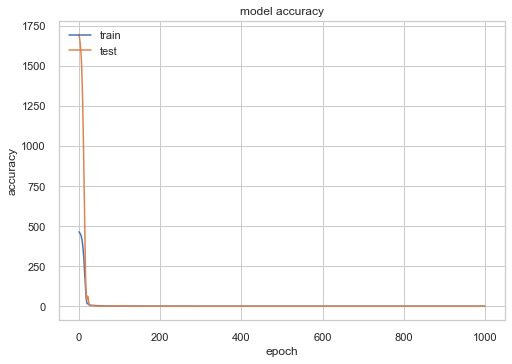

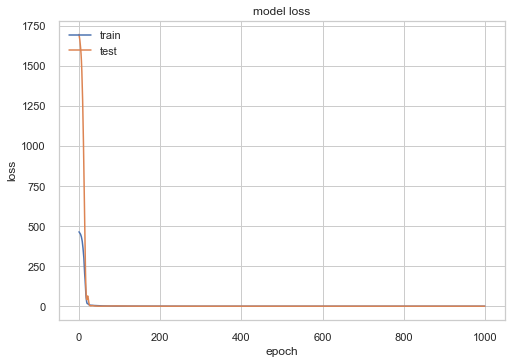

In [48]:
show_history(history)

In [49]:
from keras.layers import Bidirectional

model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(1, 1)))
model.add(Dense(2))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

history = model.fit(X, Y, epochs=1000, validation_split=0.2, verbose=0, batch_size=3)
test_output = model.predict(test_input, verbose=0)
print(test_output)

[[11.022211 12.012504]]


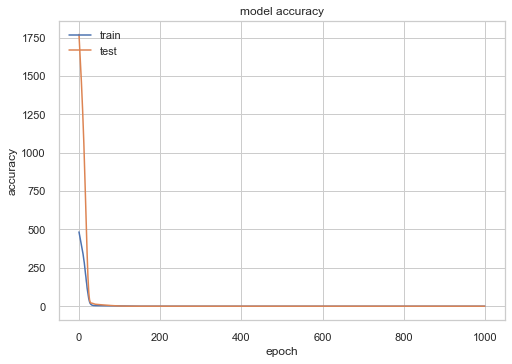

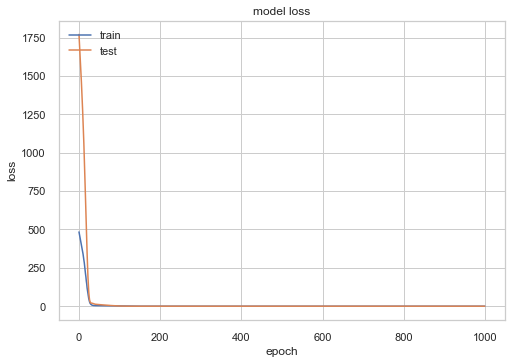

In [50]:
show_history(history)

In [52]:
X = []
Y = []
X = [x for x in range(5, 301, 5)]
Y = [y for y in range(20, 316, 5)]

In [53]:
print(X)
print(Y)

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300]
[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315]


In [54]:
X = np.array(X).reshape(20, 3, 1)
Y = np.array(Y).reshape(20, 3, 1)

In [55]:
print(X)
print(Y)

[[[  5]
  [ 10]
  [ 15]]

 [[ 20]
  [ 25]
  [ 30]]

 [[ 35]
  [ 40]
  [ 45]]

 [[ 50]
  [ 55]
  [ 60]]

 [[ 65]
  [ 70]
  [ 75]]

 [[ 80]
  [ 85]
  [ 90]]

 [[ 95]
  [100]
  [105]]

 [[110]
  [115]
  [120]]

 [[125]
  [130]
  [135]]

 [[140]
  [145]
  [150]]

 [[155]
  [160]
  [165]]

 [[170]
  [175]
  [180]]

 [[185]
  [190]
  [195]]

 [[200]
  [205]
  [210]]

 [[215]
  [220]
  [225]]

 [[230]
  [235]
  [240]]

 [[245]
  [250]
  [255]]

 [[260]
  [265]
  [270]]

 [[275]
  [280]
  [285]]

 [[290]
  [295]
  [300]]]
[[[ 20]
  [ 25]
  [ 30]]

 [[ 35]
  [ 40]
  [ 45]]

 [[ 50]
  [ 55]
  [ 60]]

 [[ 65]
  [ 70]
  [ 75]]

 [[ 80]
  [ 85]
  [ 90]]

 [[ 95]
  [100]
  [105]]

 [[110]
  [115]
  [120]]

 [[125]
  [130]
  [135]]

 [[140]
  [145]
  [150]]

 [[155]
  [160]
  [165]]

 [[170]
  [175]
  [180]]

 [[185]
  [190]
  [195]]

 [[200]
  [205]
  [210]]

 [[215]
  [220]
  [225]]

 [[230]
  [235]
  [240]]

 [[245]
  [250]
  [255]]

 [[260]
  [265]
  [270]]

 [[275]
  [280]
  [285]]

 [[290]
  [2

In [57]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

model = Sequential()

# encoder layer
model.add(LSTM(100, activation='relu', input_shape=(3, 1)))

# repeat vector
model.add(RepeatVector(3))

# decoder layer
model.add(LSTM(100, activation='relu', return_sequences=True))

model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 100)               40800     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 3, 100)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 3, 100)            80400     
_________________________________________________________________
time_distributed_2 (TimeDist (None, 3, 1)              101       
Total params: 121,301
Trainable params: 121,301
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
%%time

history = model.fit(X, Y, epochs=1000, validation_split=0.2, verbose=0, batch_size=3)

CPU times: user 1min 8s, sys: 14 s, total: 1min 22s
Wall time: 35.4 s


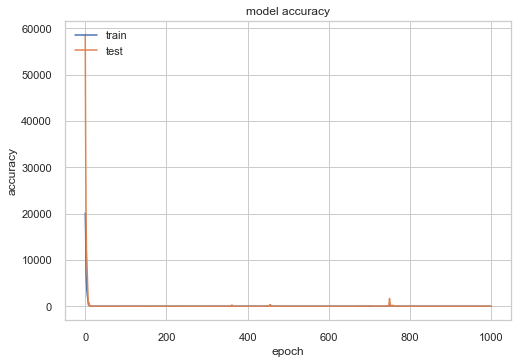

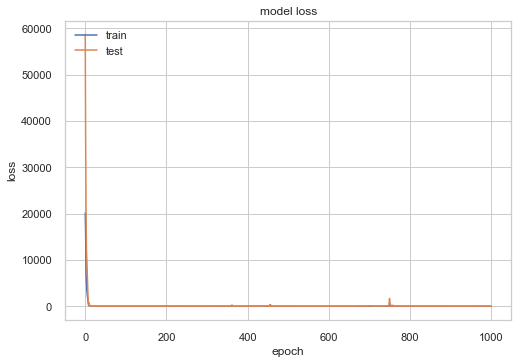

In [59]:
show_history(history)

In [60]:
test_input = array([300, 305, 310])
test_input = test_input.reshape((1, 3, 1))
test_output = model.predict(test_input, verbose=0)
print(test_output)

[[[316.11832]
  [322.61804]
  [328.87027]]]


In [63]:
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', input_shape=(3, 1))))
model.add(RepeatVector(3))
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True)))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [66]:
%%time

history = model.fit(X, Y, epochs=1000, validation_split=0.2, verbose=0, batch_size=3)

CPU times: user 3min 19s, sys: 56.3 s, total: 4min 15s
Wall time: 1min 22s


In [69]:
print(model.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 200)               81600     
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 3, 200)            0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 3, 200)            240800    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 3, 1)              201       
Total params: 322,601
Trainable params: 322,601
Non-trainable params: 0
_________________________________________________________________
None


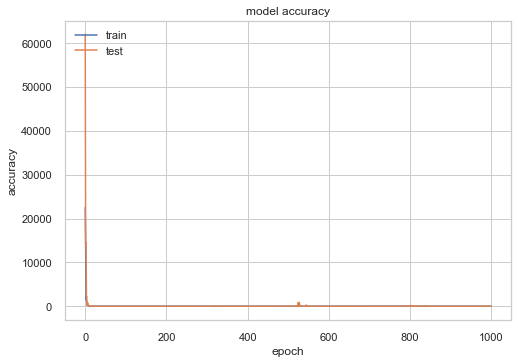

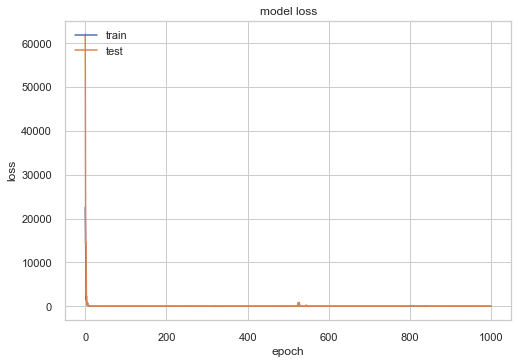

In [67]:
show_history(history)

In [68]:
test_output = model.predict(test_input, verbose=0)
print(test_output)

[[[315.63058]
  [321.0173 ]
  [326.53473]]]


In [167]:
train.shape, target.shape, test.shape

((4000, 1, 1100), (4000, 1, 1100), (2000, 1, 1100))

In [109]:
train[1][0]

array([122.26   , 112.87276, 120.12551, ..., 157.72449, 159.12724,
       137.45   ], dtype=float32)

In [77]:
target[0]

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [116]:
z = np.array([[[1, 2, 3, 4]],
         [[5, 6, 7, 8]],
         [[9, 10, 11, 12]]])

In [117]:
z.shape

(3, 1, 4)

In [118]:
z.reshape(-1)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [119]:
z.reshape(-1,1)

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12]])

In [120]:
z.reshape(3,4)

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12]])

In [121]:
target.shape

(4000, 1, 1100)

In [161]:
train_X = train.reshape(train.shape[0], train.shape[2])
train_y = target.reshape(target.shape[0], target.shape[2])
test_X = test.reshape(test.shape[0], test.shape[2])

In [162]:
train_X.shape, train_y.shape, test_X.shape

((4000, 1100), (4000, 1100), (2000, 1100))

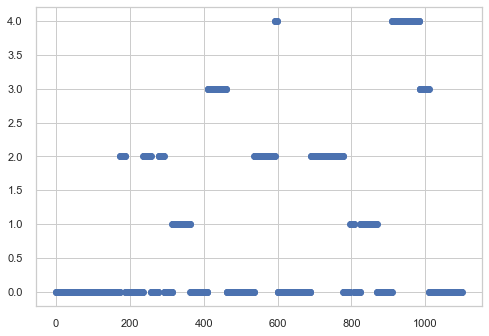

In [163]:
plt.scatter(list(range(0, 1100)), train_y[0])

In [151]:
def to_categorical(sequences, categories):
    cat_sequences = []
    for s in sequences:
        cats = []
        for item in s:
            tmp = np.zeros(categories)
            tmp[int(item)] = 1.0
            cats.append(np.zeros(categories))
        cat_sequences.append(cats)
    return np.array(cat_sequences)

In [152]:
cat_train_tags_y = to_categorical(train_y, 5)
print(cat_train_tags_y[0])

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [155]:
cat_train_tags_y.shape

(4000, 1100, 5)

In [168]:
model = Sequential()
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(1100)))
model.add(Activation('softmax'))
 
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])

In [169]:
%%time

# history = model.fit(train_X, train_y, epochs=100, validation_split=0.2, verbose=1, batch_size=128)
history = model.fit(train, target, epochs=100, validation_split=0.2, verbose=1, batch_size=128)

Train on 3200 samples, validate on 800 samples
Epoch 1/100
3200/3200 [==============================] - 3s 856us/step - loss: 9114.9161 - accuracy: 3.1250e-04 - val_loss: 8986.7647 - val_accuracy: 0.0000e+00
Epoch 2/100
3200/3200 [==============================] - 2s 488us/step - loss: 9082.1380 - accuracy: 3.1250e-04 - val_loss: 8980.5258 - val_accuracy: 0.0000e+00
Epoch 3/100
3200/3200 [==============================] - 2s 594us/step - loss: 9078.3561 - accuracy: 6.2500e-04 - val_loss: 8978.6206 - val_accuracy: 0.0000e+00
Epoch 4/100
3200/3200 [==============================] - 2s 591us/step - loss: 9077.6363 - accuracy: 3.1250e-04 - val_loss: 8976.9646 - val_accuracy: 0.0012
Epoch 5/100
3200/3200 [==============================] - 2s 548us/step - loss: 9076.7917 - accuracy: 6.2500e-04 - val_loss: 8977.6564 - val_accuracy: 0.0000e+00
Epoch 6/100
3200/3200 [==============================] - 2s 531us/step - loss: 9076.9489 - accuracy: 0.0000e+00 - val_loss: 8977.5746 - val_accuracy: 0.

In [158]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling build() or calling fit() with some data. Or specify input_shape or batch_input_shape in the first layer for automatic build. 